<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting "Greenness" Of Content

_Authors: Joseph Nelson (DC), Kiefer Katovich (SF)_

---


This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
%matplotlib inline

# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

### 1. Load the data
- Note it is a `.tsv` file and has a tab separator instead of comma.
- Clean the `is_news` column.
- Make two new columns, `title` and `body`, from the `boilerplate` column.

> **Note:** The `boilerplate` column is in json dictionary format. You can use the `json.loads()` function from the `json` module to convert this into a python dictionary.

In [2]:
evergreen_tsv = './datasets/evergreen_sites.tsv'

In [3]:
# A:
df = pd.read_csv(evergreen_tsv, sep='\t')
df.shape

(7395, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  7395 non-null object
alchemy_category_score            7395 non-null object
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_r

In [5]:
# clean is_news column
df['is_news'].unique()

array(['1', '?'], dtype=object)

In [6]:
# replace ? with 0
df.loc[:,'is_news'] = df['is_news'].map(lambda x: 0 if x == '?' else int(x))
df['is_news'].value_counts()

1    4552
0    2843
Name: is_news, dtype: int64

In [7]:
# check alchemy category score
df['alchemy_category_score'].value_counts().sort_values(ascending=False)

?            2342
0.85           82
0.0784091      40
0.849999       12
0.535009       10
0.70677         9
0.33273         7
0.400001        6
0.65146         6
0.9             5
0.849997        5
0.4875          4
0.722028        3
0.287329        3
0.849994        3
0.849995        3
0.786501        3
0.21965         3
0.899999        3
0.25991         3
0.899997        3
0.876315        2
0.186843        2
0.719157        2
0.84999         2
0.899994        2
0.899995        2
0.633187        2
0.849893        2
0.134093        2
             ... 
0.481009        1
0.622508        1
0.399148        1
0.781022        1
0.502157        1
0.596334        1
0.893983        1
0.347449        1
0.182184        1
0.891122        1
0.61871         1
0.177676        1
0.322595        1
0.853168        1
0.299152        1
0.692636        1
0.756223        1
0.601724        1
0.563783        1
0.767711        1
0.864           1
0.664512        1
0.638708        1
0.846218        1
0.650339  

In [8]:
# check those rows with '?'
# now we know that the score is 0 because there is no category
print(df[df['alchemy_category_score'] == '?'].alchemy_category.value_counts())


?    2342
Name: alchemy_category, dtype: int64


In [9]:
# Since our concern is to predict greeness of content, lets just drop the alchemy category score column
# Column might be useful for us if we intent to predict category scores
new_df = df.drop(labels='alchemy_category_score', axis=1)

In [10]:
# replace '? in alchemy_categoy to 'unknown'
new_df.loc[:,'alchemy_category'] = new_df['alchemy_category'].map(lambda x: 'unknown' if x == '?' else x)

In [11]:
# check news_front_page column
new_df['news_front_page'].value_counts()

0    5853
?    1248
1     294
Name: news_front_page, dtype: int64

In [12]:
# lets just drop those rows with '?'
index_to_drop = new_df[new_df['news_front_page']=='?'].index.tolist()
neww_df = new_df.drop(labels=index_to_drop)
neww_df.loc[:,'news_front_page'] = neww_df['news_front_page'].astype('int64')

In [13]:
# Now lets get two new columns from boiler plate, title & body
# first we convert boilerplate values into python dicts
bp_dict = neww_df.boilerplate.map(lambda x: json.loads(x))
'title' in bp_dict.values[0].keys()

True

In [14]:
# now we make 2 new copies of it, 1 for title and the other for body
title_dict = bp_dict.copy(deep=True)
body_dict = bp_dict.copy(deep=True)

In [15]:
# extract title into title column else put Nan
# do the same for body
# then combine them with main dataframe
neww_df['title'] = title_dict.map(lambda x: x['title'] if 'title' in x.keys() else np.nan)
neww_df['body'] = body_dict.map(lambda x: x['body'] if 'body' in x.keys() else np.nan)

In [16]:
neww_df.isnull().sum().sort_values(ascending=False)

body                              51
title                             10
urlid                              0
boilerplate                        0
alchemy_category                   0
avglinksize                        0
commonlinkratio_1                  0
commonlinkratio_2                  0
commonlinkratio_3                  0
commonlinkratio_4                  0
compression_ratio                  0
embed_ratio                        0
framebased                         0
frameTagRatio                      0
hasDomainLink                      0
html_ratio                         0
image_ratio                        0
is_news                            0
lengthyLinkDomain                  0
linkwordscore                      0
news_front_page                    0
non_markup_alphanum_characters     0
numberOfLinks                      0
numwords_in_url                    0
parametrizedLinkRatio              0
spelling_errors_ratio              0
label                              0
u

In [17]:
# remove the nan rows for title and body
newww_df = neww_df.dropna()

In [18]:
# check whether binary columns are really binary
binary_cols = ['framebased','hasDomainLink','is_news','lengthyLinkDomain','news_front_page','label']
for col in binary_cols:
    print(newww_df[col].value_counts())
    print('')

0    6086
Name: framebased, dtype: int64

0    5970
1     116
Name: hasDomainLink, dtype: int64

1    4503
0    1583
Name: is_news, dtype: int64

1    4032
0    2054
Name: lengthyLinkDomain, dtype: int64

0    5794
1     292
Name: news_front_page, dtype: int64

1    3147
0    2939
Name: label, dtype: int64



In [19]:
# final check using describe
newww_df.describe()

,urlid,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
count,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.0,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000
mean,5306.255012,2.824336,0.461575,0.211517,0.090911,0.049844,1.749451,-0.072973,0.0,0.056229,0.019060,0.233359,0.321959,0.739895,0.662504,29.813506,0.047979,5471.625041,178.563424,4.975353,0.175509,0.098502,0.517088
std,3051.158085,9.319572,0.202155,0.146517,0.094888,0.073258,4.859807,0.262079,0.0,0.040986,0.136748,0.051703,2.023112,0.438728,0.472894,19.958146,0.213739,7922.190442,181.743168,3.226134,0.181930,0.068204,0.499749
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.063777,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2673.250000,1.588130,0.333333,0.102624,0.021277,0.000000,0.443113,0.000000,0.0,0.028640,0.000000,0.200960,0.032303,0.000000,0.000000,14.000000,0.000000,1595.000000,82.000000,3.000000,0.044513,0.068966,0.000000
50%,5321.000000,2.084274,0.476190,0.200000,0.067624,0.023415,0.482242,0.000000,0.0,0.046233,0.000000,0.229839,0.089895,1.000000,1.000000,25.000000,0.000000,3512.500000,139.000000,5.000000,0.117483,0.088730,1.000000
75%,7959.750000,2.638098,0.607687,0.295238,0.133061,0.066667,0.561549,0.000000,0.0,0.073001,0.000000,0.259791,0.247767,1.000000,1.000000,43.000000,0.000000,6304.750000,222.000000,7.000000,0.242424,0.111111,1.000000
max,10566.000000,363.000000,1.000000,1.000000,0.980392,0.980392,21.000000,0.250000,0.0,0.444444,1.000000,0.716883,113.333333,1.000000,1.000000,100.000000,1.000000,180020.000000,4997.000000,22.000000,1.000000,1.000000,1.000000


In [20]:
# drop framebased since all 0, unable to predict anything with it
newwww_df = newww_df.drop(labels='framebased',axis=1)

### 2. What are 'evergreen' sites?
- These are websites that always relevant like recipes or reviews (as opposed to current events).
- Stored as a binary indicator in the `label` column.
- Look at some examples.

In [21]:
# A:
newwww_df[newwww_df['label'] == 1].head(2)

,url,urlid,boilerplate,alchemy_category,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-advantages-races,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races"",""body"":""And that can be carried on a pla...",recreation,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Health-_-FightFluWithFruit,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body"":""Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent hea...",health,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...


In [22]:
newwww_df[newwww_df['label'] == 0].head(2)

,url,urlid,boilerplate,alchemy_category,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at...",business,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...
4,http://bleacherreport.com/articles/1205138-the-50-coolest-jerseys-you-didnt-know-existed?show_full=,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen"",""body"":""Jersey sales is a curious business Whether you re buying the stylish top to represent your favorite team player or color you re always missing out on better artwork With No 18 Colts jerseys continu...",sports,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,Jersey sales is a curious business Whether you re buying the stylish top to represent your favorite team player or color you re always missing out on better artwork With No 18 Colts jerseys continuing to flood the streets it s about time we educate the sports public about the real masterpieces t...


### 3. Does being a news site affect green-ness?

**3.A Investigate with plots/EDA.**

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


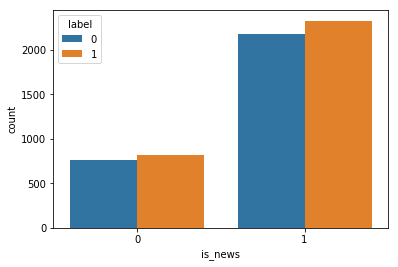

In [23]:
# A:
sns.countplot(x='is_news', hue='label', data=newwww_df[['is_news','label']])

In [24]:
# Apparently not, if they are we should observe a huge difference between evergreen or not when sites is a news

**3.B Test the hypothesis with a logistic regression using statsmodels.**

> **Hint:** The `sm.logit` function from `statsmodels.formula.api` will perform a logistic regression using a formula string.

In [25]:
import statsmodels.formula.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [26]:
# A:
news_data = newwww_df[['label','is_news']]
formula = 'label ~ is_news'
news_model = sm.logit(formula, data=news_data).fit()
news_model.summary()

Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6084
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:               2.433e-06
Time:                        18:11:53   Log-Likelihood:                -4214.9
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                    0.8861
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0746      0.050      1.483      0.138      -0.024       0.173
is_news       -0.0084      0.058     -0.143      0.886      -0.123       0.106
==============================================================================
"""

**3.C Interpret the results of your model.**

In [27]:
# A:
# effect of site being news is statistically insignificant on evergreeness of site
# Accept Null hypothesis that news site and non-news site have equal probability of being evergreen

### 4. Does the website category affect green-ness?

**4.A Investigate with plots/EDA.**

In [28]:
# A:
# check probability of site being evergreen for each website category
newwww_df.groupby(['alchemy_category'])['label'].mean()

alchemy_category
arts_entertainment    0.373453
business              0.716687
computer_internet     0.257042
culture_politics      0.461059
gaming                0.342466
health                0.581053
law_crime             0.444444
recreation            0.693424
religion              0.420290
science_technology    0.453532
sports                0.206044
unknown               0.494262
weather               0.000000
Name: label, dtype: float64

In [29]:
# for each category, score > 0.5 means probability of category being evergreen is higher

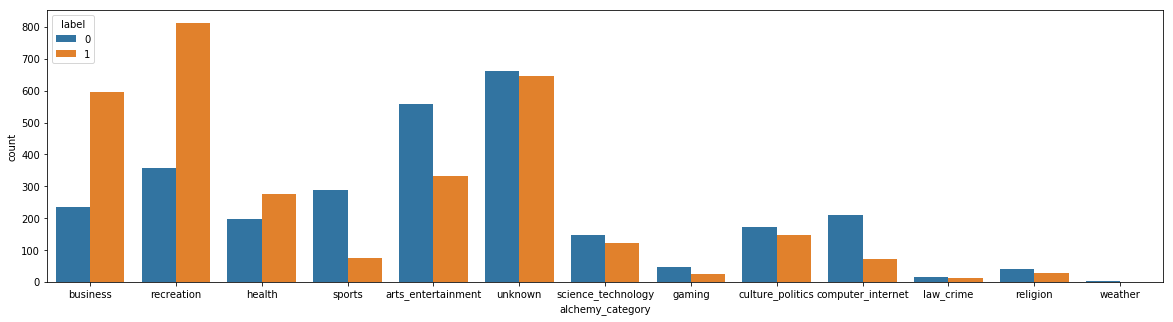

In [30]:
# now we plot countplot
category_data = newwww_df[['alchemy_category','label']]
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x='alchemy_category', hue='label', data=category_data, ax=ax)

In [31]:
# Seems like website category does affect green-ness of site

**4.B Test the hypothesis with a logistic regression.**

In [32]:
# A:
formula = "label ~ C(alchemy_category, Treatment(reference='unknown'))"
log_model = sm.logit(formula, data=category_data).fit(method='bfgs', maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.640937
         Iterations: 113
         Function evaluations: 115
         Gradient evaluations: 115


In [33]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6073
Method:                           MLE   Df Model:                           12
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:                 0.07454
Time:                        18:11:54   Log-Likelihood:                -3900.7
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                9.145e-127
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -0.0230      0.055     -0.416      0.678      -0.131       0.085
C(alchemy_category, Treatment(reference='unknown'))[T.arts_entertainment]    -0.4944      0.089     -5.574      0.000      -0.668      -0.321
C(alchemy_category, Treatment(reference='unknown'))[T.business]               0.9511      0.095     10.040      0.000       0.765       1.137
C(alchemy_category, Treatment(reference='unknown'))[T.computer_internet]     -1.0383      0.147     -7.082      0.000      -1.326      -0.751
C(alchemy_category, Treatment(reference='unknown'))[T.culture_politics]      -0.1331      0.125     -1.066      0.287      -0.378       0.112
C(alchemy_category, Treatment(reference='unknown'))[T.gaming]                -0.6304      0.253     -2.493      0.013      -1.126      -0.135
C(alchemy_category, Treatment(reference='unknown'))[T.health]                 0.3501      0.108      3.235      0.001       0.138       0.562
C(alchemy_category, Treatment(reference='unknown'))[T.law_crime]             -0.2037      0.391     -0.521      0.603      -0.971       0.563
C(alchemy_category, Treatment(reference='unknown'))[T.recreation]             0.8392      0.084      9.975      0.000       0.674       1.004
C(alchemy_category, Treatment(reference='unknown'))[T.religion]              -0.2965      0.250     -1.186      0.236      -0.787       0.194
C(alchemy_category, Treatment(reference='unknown'))[T.science_technology]    -0.1633      0.134     -1.215      0.224      -0.427       0.100
C(alchemy_category, Treatment(reference='unknown'))[T.sports]                -1.3260      0.141     -9.410      0.000      -1.602      -1.050
C(alchemy_category, Treatment(reference='unknown'))[T.weather]               -7.3486     19.951     -0.368      0.713     -46.452      31.754
=============================================================================================================================================
"""

**4.C Interpret the model results.**

In [34]:
# A:
# Categories must be read as significantly different from unknown or not
# categories that are insignificant are the following:
# - weather
# - science technology
# - religion
# - law crime
# - culture politics

# Among the categories that are significant:

# Positive predictors of greeness
# - Business
# - Health
# - Recreation

# Negative predictors of greeness
# - Arts Entertainment
# - Computer Internet
# - Gaming
# - Sports

### 5. Does the image ratio affect green-ness?

**5.A Investigate with plots/EDA.**

In [35]:
# A:
image_data = newwww_df[['label','image_ratio']]
image_data.head()

,label,image_ratio
0,0,0.003883
1,1,0.088652
2,1,0.120536
3,1,0.035343
4,0,0.050473


In [36]:
# cut the image_ratio into 5 bins in ascending value
pd.qcut(image_data['image_ratio'], 5).value_counts().sort_values(ascending=False)

(-1.001, 0.0237]    1218
(0.0237, 0.0623]    1218
(0.134, 0.322]      1217
(0.322, 113.333]    1217
(0.0623, 0.134]     1216
Name: image_ratio, dtype: int64

In [37]:
image_data['image_ratio_binned'] = pd.qcut(image_data['image_ratio'], 5)
image_data.head(5)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,label,image_ratio,image_ratio_binned
0,0,0.003883,"(-1.001, 0.0237]"
1,1,0.088652,"(0.0623, 0.134]"
2,1,0.120536,"(0.0623, 0.134]"
3,1,0.035343,"(0.0237, 0.0623]"
4,0,0.050473,"(0.0237, 0.0623]"


In [38]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6086 entries, 0 to 7393
Data columns (total 3 columns):
label                 6086 non-null int64
image_ratio           6086 non-null float64
image_ratio_binned    6086 non-null category
dtypes: category(1), float64(1), int64(1)
memory usage: 308.7 KB


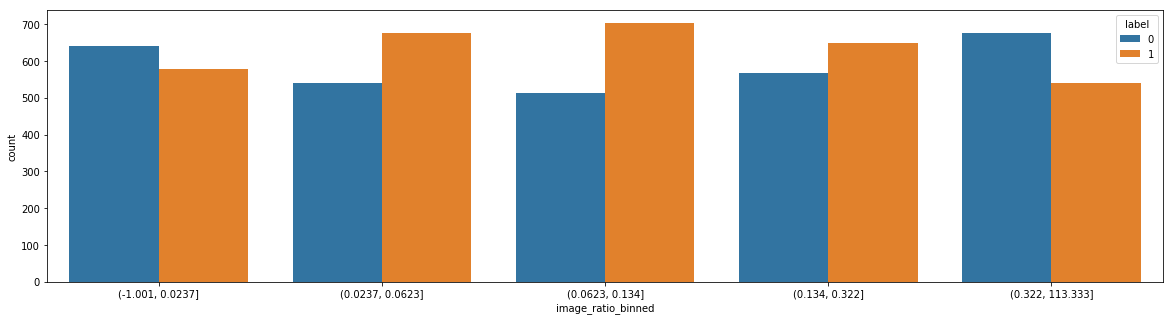

In [39]:
# Now we can take a look at the greeness for each category of image_ratio
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x='image_ratio_binned', hue='label', data=image_data, ax=ax)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


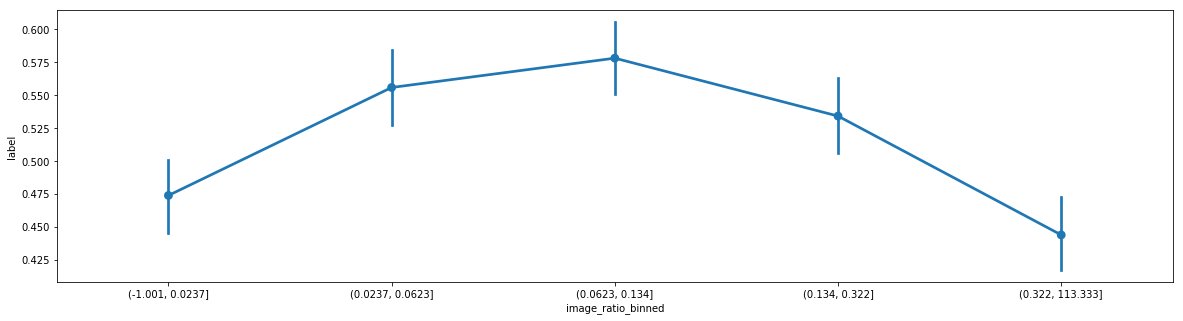

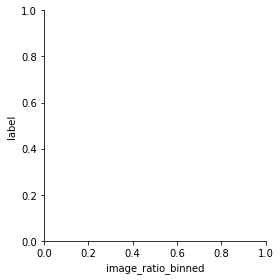

In [40]:
fig, ax = plt.subplots(figsize=(20,5))
sns.factorplot(x='image_ratio_binned', y='label', data=image_data, ax=ax)

In [41]:
# quadratic curve means we have to come up with a quadratic equation for our regression

**5.B Test the hypothesis using a logistic regression.**

> **Note**: It is worth thinking about how to best represent this variable. It may not be wise to input the image ratio as-is.

In [42]:
# A: 
formula = 'label ~ image_ratio + np.power(image_ratio,2)'
model = sm.logit(formula, data=image_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.692176
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6083
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:               0.0005589
Time:                        18:11:55   Log-Likelihood:                -4212.6
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                   0.09484
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0818      0.026      3.088      0.002       0.030       0.134
image_ratio                 -0.0491      0.024     -2.080      0.038      -0.095      -0.003
np.power(image_ratio, 2)     0.0006      0.000      1.701      0.089    -8.9e-05       0.001
============================================================================================
"""

In [43]:
# something wrong here, linear function should have positive effect while quadratic should have negative effect

In [44]:
image_data['image_ratio_pctl'] = image_data.image_ratio.map(lambda x: stats.percentileofscore(image_data.image_ratio.values, x))

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
formula = 'label ~ image_ratio_pctl + np.power(image_ratio_pctl,2)'
model = sm.logit(formula, data=image_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6083
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:                0.008807
Time:                        18:12:00   Log-Likelihood:                -4177.8
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                 7.554e-17
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3531      0.078     -4.553      0.000      -0.505      -0.201
image_ratio_pctl                  0.0280      0.004      7.797      0.000       0.021       0.035
np.power(image_ratio_pctl, 2)    -0.0003   3.48e-05     -8.433      0.000      -0.000      -0.000
=================================================================================================
"""

In [46]:
# now it looks like our EDA hahah

**5.C Interpret the model.**

In [47]:
# A:

# Positive effect from image ratio

# Negative quadratic effect of image ratio. Which means at a certain point the curve starts to turn downwards.
# From this we can tell that the median values has the most positive effects on evergreen

### 6. Fit a logistic regression with multiple predictors.
- The choice of predictors is up to you. Test features you think may be valuable to predict evergreen status.
- Do any EDA you may need.
- Interpret the coefficients of the model.

> **Tip:** [This pdf is very useful for an overview of interpreting logistic regression coefficients.](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)

In [48]:
newwww_df.columns

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category', u'avglinksize',
       u'commonlinkratio_1', u'commonlinkratio_2', u'commonlinkratio_3',
       u'commonlinkratio_4', u'compression_ratio', u'embed_ratio',
       u'frameTagRatio', u'hasDomainLink', u'html_ratio', u'image_ratio',
       u'is_news', u'lengthyLinkDomain', u'linkwordscore', u'news_front_page',
       u'non_markup_alphanum_characters', u'numberOfLinks', u'numwords_in_url',
       u'parametrizedLinkRatio', u'spelling_errors_ratio', u'label', u'title',
       u'body'],
      dtype='object')

In [49]:
# A:
# lets try out spelling error ratio & news front page
temp_data = newwww_df[['label','spelling_errors_ratio','html_ratio']]
temp_data.describe()

,label,spelling_errors_ratio,html_ratio
count,6086.000000,6086.000000,6086.000000
mean,0.517088,0.098502,0.233359
std,0.499749,0.068204,0.051703
min,0.000000,0.000000,0.063777
25%,0.000000,0.068966,0.200960
50%,1.000000,0.088730,0.229839
75%,1.000000,0.111111,0.259791
max,1.000000,1.000000,0.716883


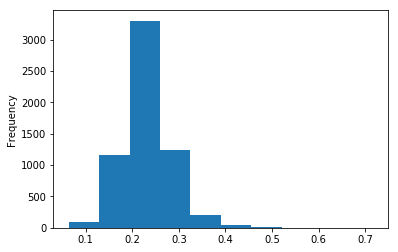

In [50]:
temp_data['html_ratio'].plot(kind='hist')

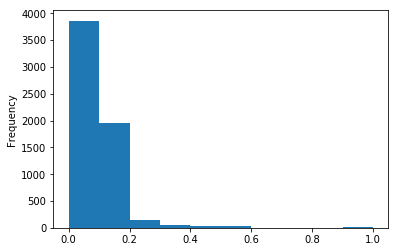

In [51]:
temp_data['spelling_errors_ratio'].plot(kind='hist')

In [52]:
# EDA for front page news
temp_data['spelling_errors_ratio_binned'] = pd.qcut(temp_data['spelling_errors_ratio'], 5)
temp_data['html_ratio_binned'] = pd.qcut(temp_data['html_ratio'], 5)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


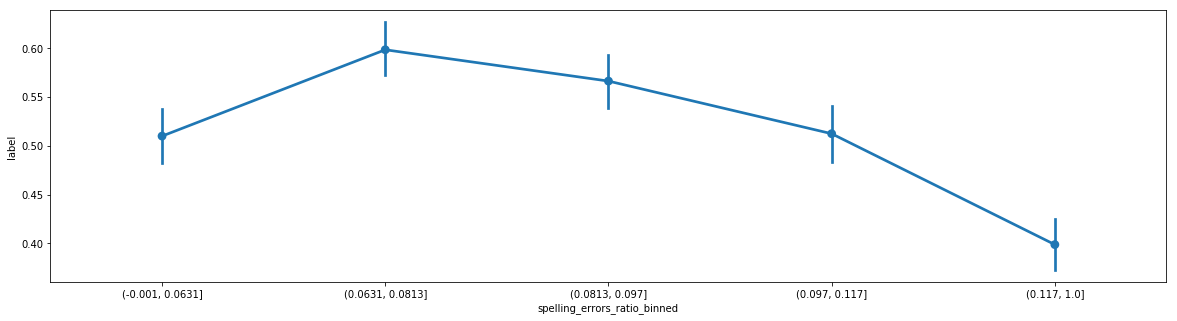

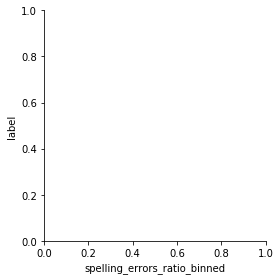

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
sns.factorplot(x='spelling_errors_ratio_binned', y='label', data=temp_data, ax=ax)

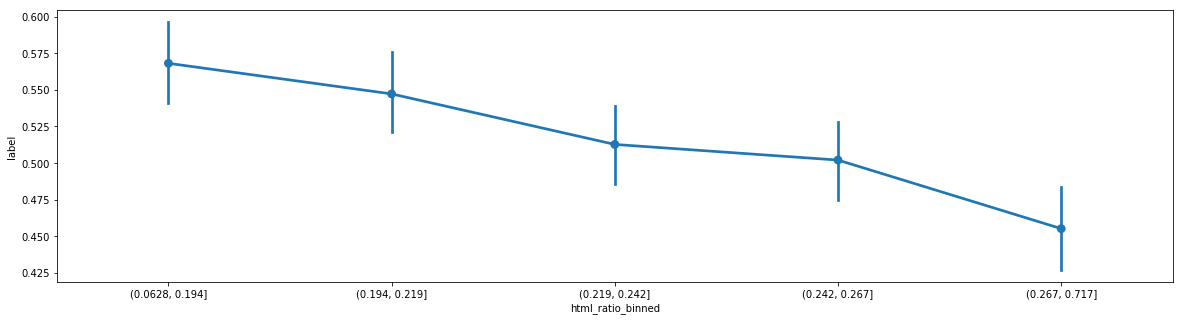

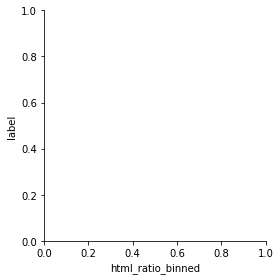

In [54]:
fig, ax = plt.subplots(figsize=(20,5))
sns.factorplot(x='html_ratio_binned', y='label', data=temp_data, ax=ax)

In [55]:
# spelling errors have quadratic function
# html ratio is linear

In [56]:
# convert both to ranks using stats.percentile
temp_data['spelling_errors_ratio_pctl'] = temp_data.spelling_errors_ratio.map(lambda x: stats.percentileofscore(temp_data.spelling_errors_ratio.values, x))
temp_data['html_ratio_pctl'] = temp_data.html_ratio.map(lambda x: stats.percentileofscore(temp_data.html_ratio.values, x))

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
# now we log individual models first
formula = 'label ~ spelling_errors_ratio_pctl'
model = sm.logit(formula, data=temp_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.688854
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6084
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:                0.005355
Time:                        18:12:12   Log-Likelihood:                -4192.4
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                 1.829e-11
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3685      0.052      7.120      0.000       0.267       0.470
spelling_errors_ratio_pctl    -0.0060      0.001     -6.697      0.000      -0.008      -0.004
==============================================================================================
"""

In [58]:
formula = 'label ~ html_ratio_pctl'
model = sm.logit(formula, data=temp_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.689872
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6084
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:                0.003886
Time:                        18:12:12   Log-Likelihood:                -4198.6
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                 1.042e-08
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3237      0.052      6.268      0.000       0.222       0.425
html_ratio_pctl    -0.0051      0.001     -5.710      0.000      -0.007      -0.003
===================================================================================
"""

In [59]:
# combine all with image ratio
temp_data['image_ratio_pctl'] = image_data['image_ratio_pctl']

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
formula = 'label ~ html_ratio_pctl + spelling_errors_ratio_pctl + image_ratio_pctl + np.power(image_ratio_pctl,2)'
model = sm.logit(formula, data=temp_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.678206
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 6086
Model:                          Logit   Df Residuals:                     6081
Method:                           MLE   Df Model:                            4
Date:                Wed, 27 Dec 2017   Pseudo R-squ.:                 0.02073
Time:                        18:12:12   Log-Likelihood:                -4127.6
converged:                       True   LL-Null:                       -4214.9
                                        LLR p-value:                 9.961e-37
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.5772      0.122      4.734      0.000       0.338       0.816
html_ratio_pctl                  -0.0080      0.001     -7.763      0.000      -0.010      -0.006
spelling_errors_ratio_pctl       -0.0059      0.001     -6.457      0.000      -0.008      -0.004
image_ratio_pctl                  0.0230      0.004      6.288      0.000       0.016       0.030
np.power(image_ratio_pctl, 2)    -0.0003   3.53e-05     -8.188      0.000      -0.000      -0.000
=================================================================================================
"""

In [66]:
model.params

Intercept                        0.577157
html_ratio_pctl                 -0.007955
spelling_errors_ratio_pctl      -0.005932
image_ratio_pctl                 0.023003
np.power(image_ratio_pctl, 2)   -0.000289
dtype: float64

In [61]:
# when
np.exp(model.params)

Intercept                        1.780968
html_ratio_pctl                  0.992076
spelling_errors_ratio_pctl       0.994086
image_ratio_pctl                 1.023270
np.power(image_ratio_pctl, 2)    0.999711
dtype: float64

In [62]:
# for 1 unit increase in html ratio, the log odds of evergreen decrease by ~ 0.992076
# apply same protocol for all the parameters

In [63]:
title_data = newwww_df[['title','label']]

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


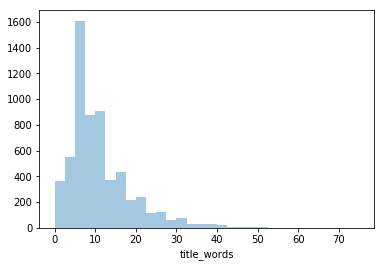

In [64]:
def title_len(x):
    try:
        return len(x.split())
    except:
        return 0.

# calculate the number of words in the title and plot distribution
title_data['title_words'] = title_data.title.map(title_len)
sns.distplot(title_data.title_words, bins=30, kde=False)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


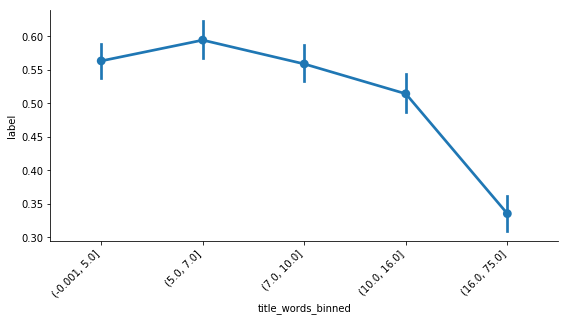

In [65]:
title_data['title_words_binned'] = pd.qcut(title_data['title_words'], 5)

sns.factorplot('title_words_binned', 'label', data=title_data, aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right')